In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import time
import matplotlib

from compute_walk import compute_walk

import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns

## Import data file

In [3]:
data = pd.read_csv('/home/leo/python_scripts/myNotebooks/pyCO2_MonteCarlo/input_data_Cesar_Mediterraneo_onlyTPBcorr.csv')

In [4]:
data

,Time,d11B_foram,2SD_d11Bf,Temperature,2SD_temp,Salinity,2SD_sal,d11B_sw,2SD_d11Bsw,alkalinity,2SD_alk,Pressure
0,2011.18,17.86,0.2,23.70,1.4,37.8,0.5,39.61,0.05,2550,50,25
1,2004.29,17.76,0.2,23.48,1.4,37.8,0.5,39.61,0.05,2550,50,25
2,2000.31,17.96,0.2,21.50,1.4,37.8,0.5,39.61,0.05,2550,50,25
3,1996.32,16.24,0.2,22.84,1.4,37.8,0.5,39.61,0.05,2550,50,25
4,1992.58,17.35,0.2,21.80,1.4,37.8,0.5,39.61,0.05,2550,50,25
...,...,...,...,...,...,...,...,...,...,...,...,...
99,1885.26,17.92,0.2,20.98,1.4,37.5,0.5,39.61,0.05,2478,50,25
100,1873.89,18.21,0.2,21.09,1.4,37.5,0.5,39.61,0.05,2478,50,25
101,1863.63,17.55,0.2,21.31,1.4,37.5,0.5,39.61,0.05,2478,50,25
102,1853.38,17.90,0.2,20.46,1.4,37.5,0.5,39.61,0.05,2478,50,25


## Define parameters for borate equation

In [5]:
# G. sacculer Foster equation
#C = 3.6
#M = 0.834

# Trilobatus
#C = 2.69
#M = 0.833

# Bulloides
#C = -3.27
#M = 1.06

# O Universa Pernice
#C = -0.42
#M = 0.95

# O Universa  Cesar
C = -2.08
M = 1.06

#C_SD = 0.722 / 2
#M_SD = 0.036 / 2

C_SD = 0
M_SD = 0

# Define the number of steps ("walks") for the MC simulation

In [6]:
total_walks = 100

## Define workers and get_results functions for parallel processing

In [7]:
def workers():
    tmp_res = compute_walk(data, C, M, C_SD, M_SD)
    return tmp_res
    
def get_results(tmp_res):
    
    global MC_list_pH; global MC_list_pCO2
    
    MC_list_pH.append(tmp_res[0])
    MC_list_pCO2.append(tmp_res[1])

In [8]:
MC_list_pH = []
MC_list_pCO2 = []

start_time = time.time()

if __name__ == '__main__':
    
    # Start CPU pool
    pool = mp.Pool(mp.cpu_count())
    
    # Lauch threads to CPUs available
    for i in range(total_walks):
        #pool.apply_async(workers, (),)
        pool.apply_async(workers, (), callback=get_results)
                
    while pool._cache:
        current_time = time.time()
        if len(pool._cache) < total_walks:
            rate = ((total_walks - len(pool._cache))) / (current_time - start_time)
            print('               Estimated time to completion:', time.strftime('%H:%M:%S', time.gmtime(len(pool._cache) / rate)), "   ", end="\r")
        print(f"Pool: ", len(pool._cache), "   ", end="\r")
        
        time.sleep(2)
       
    # clean up
    pool.close()
    pool.join()

In [9]:
index = MC_list_pCO2[0].index

df_avg = pd.DataFrame()

#data_pCO2 = []
mean_pCO2 = []
median_pCO2 = []
stdev_pCO2 = []
p_05_pCO2 = []
p_95_pCO2 = []

for idx in index:
    dat = []
    
    for i in range(len(MC_list_pCO2)):
        values = MC_list_pCO2[i].loc[idx]
        dat.append(values)
        
    mean = np.mean(dat)
    stdev = np.std(dat)
    median = np.median(dat)
    per_05 = np.percentile(dat, 5)
    per_95 = np.percentile(dat, 95)
    #stdev = np.std(dat, ddof=1) / np.sqrt(len(MC_list_pCO2)) * 2
    
    mean_pCO2.append(mean)
    stdev_pCO2.append(stdev)
    median_pCO2.append(median)
    p_05_pCO2.append(per_05)
    p_95_pCO2.append(per_95)

df_avg['Time'] = data['Time']
df_avg['pCO2'] = mean_pCO2
df_avg['pCO2_stdv'] = stdev_pCO2
df_avg['pCO2_median'] = median_pCO2
df_avg['pCO2_per05'] = p_05_pCO2
df_avg['pCO2_per95'] = p_95_pCO2

In [10]:
#df_avg.to_csv('/home/leo/data/output_cesar_med.csv')

Text(0.5, 0, 'Time (ka)')

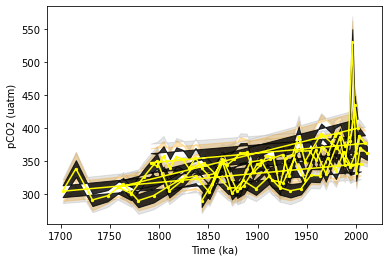

In [11]:
plt.fill_between(df_avg['Time'], df_avg['pCO2_per05'], df_avg['pCO2_per95'], color='orange', alpha=0.3)
plt.fill_between(df_avg['Time'], df_avg['pCO2'] + df_avg['pCO2_stdv'] * 2, df_avg['pCO2'] - df_avg['pCO2_stdv'] * 2, color='grey', alpha=0.2)
plt.fill_between(df_avg['Time'], df_avg['pCO2'] + df_avg['pCO2_stdv'] * 1, df_avg['pCO2'] - df_avg['pCO2_stdv'] * 1, color='black', alpha=0.8)

plt.plot(df_avg['Time'], df_avg['pCO2'], c='yellow')
plt.scatter(df_avg['Time'], df_avg['pCO2'], s=5, c='yellow')

plt.ylabel('pCO2 (uatm)')
plt.xlabel('Time (ka)')

In [12]:
index = MC_list_pH[0].index

df_pH_avg = pd.DataFrame()

#data_pH = []
mean_pH = []
median_pH = []
stdev_pH = []
p_05_pH = []
p_10_pH = []
p_15_pH = []
p_20_pH = []
p_25_pH = []
p_75_pH = []
p_80_pH = []
p_85_pH = []
p_90_pH = []
p_95_pH = []

for idx in index:
    dat = []
    
    for i in range(len(MC_list_pH)):
        values = MC_list_pH[i].loc[idx]
        dat.append(values)
        
    mean = np.mean(dat)
    stdev = np.std(dat)
    median = np.median(dat)
    per_05 = np.percentile(dat, 5)
    per_10 = np.percentile(dat, 10)
    per_15 = np.percentile(dat, 15)
    per_20 = np.percentile(dat, 20)
    per_25 = np.percentile(dat, 25)
    per_75 = np.percentile(dat, 75)
    per_80 = np.percentile(dat, 80)
    per_85 = np.percentile(dat, 85)
    per_90 = np.percentile(dat, 90)
    per_95 = np.percentile(dat, 95)
    #stdev = np.std(dat, ddof=1) / np.sqrt(len(MC_list_pH)) * 2
    
    mean_pH.append(mean)
    stdev_pH.append(stdev)
    median_pH.append(median)
    p_05_pH.append(per_05)
    p_10_pH.append(per_10)
    p_15_pH.append(per_15)
    p_20_pH.append(per_20)
    p_25_pH.append(per_25)
    p_75_pH.append(per_75)
    p_80_pH.append(per_80)
    p_85_pH.append(per_85)
    p_90_pH.append(per_90)
    p_95_pH.append(per_95)

df_pH_avg['Time'] = data['Time']
df_pH_avg['pH'] = mean_pH
df_pH_avg['pH_stdv'] = stdev_pH
df_pH_avg['pH_median'] = median_pH
df_pH_avg['pH_per05'] = p_05_pH
df_pH_avg['pH_per10'] = p_10_pH
df_pH_avg['pH_per15'] = p_15_pH
df_pH_avg['pH_per20'] = p_20_pH
df_pH_avg['pH_per25'] = p_25_pH
df_pH_avg['pH_per75'] = p_75_pH
df_pH_avg['pH_per80'] = p_80_pH
df_pH_avg['pH_per85'] = p_85_pH
df_pH_avg['pH_per90'] = p_90_pH
df_pH_avg['pH_per95'] = p_95_pH

In [13]:
#df_pH_avg.to_csv('/home/leo/data/output_cesar_pH_med.csv')

Text(0.5, 0, 'Time (ka)')

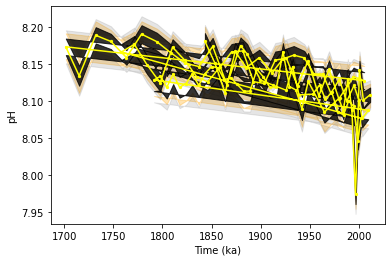

In [14]:
plt.fill_between(df_pH_avg['Time'], df_pH_avg['pH_per05'], df_pH_avg['pH_per95'], color='orange', alpha=0.3)
plt.fill_between(df_pH_avg['Time'], df_pH_avg['pH'] + df_pH_avg['pH_stdv'] * 2, df_pH_avg['pH'] - df_pH_avg['pH_stdv'] * 2, color='grey', alpha=0.2)
plt.fill_between(df_pH_avg['Time'], df_pH_avg['pH'] + df_pH_avg['pH_stdv'] * 1, df_pH_avg['pH'] - df_pH_avg['pH_stdv'] * 1, color='black', alpha=0.8)

plt.plot(df_pH_avg['Time'], df_pH_avg['pH'], c='yellow')
plt.scatter(df_pH_avg['Time'], df_pH_avg['pH'], s=5, c='yellow')

plt.ylabel('pH')
plt.xlabel('Time (ka)')